<a href="https://colab.research.google.com/github/kmouts/PMS/blob/master/PMS_6_2_UNets_and_Diffusion_Models_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright bold text

In [1]:
#@title Licensed under the Creative Commons Attribution-NonCommercial 4.0 International License (the "License");
# you may not use this file except in compliance with the License.
#
# The NVIDIA Deep Learning Institute Generative AI Teaching Kit is licensed by NVIDIA and Dartmouth College under the License.
#
# You may obtain a copy of the License at
# http://creativecommons.org/licenses/by-nc/4.0/

 Modifications/Editing: K.Moutselos
 Dept. of Digital Systems
 University of Piraeus

# 6.2 Diffusion Models - UNets

In this notebook we will
- Construct a UNet from scratch in pytorch
- Build an MNIST dataset with noise
- Train a simple diffusion model
- Sample from our diffusion model
- Compare against a pre-trained model

# Understanding U-Nets and Diffusion Models

## Introduction to U-Net Architecture

The U-Net is a convolutional neural network architecture that was originally developed for biomedical image segmentation. Its name comes from its U-shaped architecture, which consists of a contracting path (encoder) and an expansive path (decoder), connected by a bottleneck.

Key features of U-Net:

1. **Encoder (Contracting Path)**: Captures context and reduces spatial dimensions.
2. **Decoder (Expanding Path)**: Enables precise localization and increases spatial dimensions.
3. **Skip Connections**: Connect encoder layers to corresponding decoder layers, preserving fine-grained details.

U-Nets have found applications beyond image segmentation, including in generative models like diffusion models.

## U-Net in Diffusion Models

In the context of diffusion models, U-Nets are used to predict noise at each step of the denoising process. The architecture is particularly well-suited for this task because:

- It can capture both local and global features of the image.
- It can work with different scales of information.
- Skip connections help in preserving important details throughout the noising/denoising process.

## Key Components of Our U-Net Implementation

Our implementation includes several important components:

1. **DownBlock**: Reduces spatial dimensions and increases channel depth.
2. **MidBlock**: Processes features at the bottleneck of the U-Net.
3. **UpBlock**: Increases spatial dimensions and decreases channel depth.
4. **Attention Mechanisms**: Allows the model to focus on important parts of the input.
5. **Time Embedding**: Injects information about the current noise level into the model.

## The Diffusion Process

The diffusion process involves two main steps:

1. **Forward Diffusion**: Gradually add noise to an image over a fixed number of steps.
2. **Reverse Diffusion**: Learn to remove noise step by step, eventually reconstructing the original image.

Our `LinearNoiseScheduler` class handles the logistics of adding and removing noise according to a predefined schedule.

## Training and Sampling

The training process involves:

1. Sampling a random timestep.
2. Adding noise to an image according to this timestep.
3. Having the model predict the added noise.
4. Optimizing the model to minimize the difference between predicted and actual noise.

Sampling from the trained model involves:

1. Starting with pure noise.
2. Iteratively applying the model to denoise the image.
3. Following the reverse diffusion process until a clear image is produced.

## Code Structure

Our implementation is structured as follows:

1. **Model Architecture**: Defined in the `Unet`, `DownBlock`, `MidBlock`, and `UpBlock` classes.
2. **Noise Scheduler**: Implemented in the `LinearNoiseScheduler` class.
3. **Training Loop**: Encapsulated in the `train` function.
4. **Sampling**: Implemented in the `generate_samples` function.
5. **Main Execution**: Orchestrated in the `main` function.

This structure allows for a clear separation of concerns and makes the code more modular and easier to understand and modify.

By studying this implementation, you can gain a deep understanding of both U-Net architecture and diffusion models, as well as how they can be combined to create powerful generative models.

### Install Libraries

In [2]:
!pip install -qqq torchview graphviz einops matplotlib numpy opencv_python PyYAML torch torchvision tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.4 MB/s eta 0:00:00


### Import Libraries

In [3]:
import os, torch, torchvision, math, gc, graphviz
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torchvision.utils import make_grid
from tqdm import tqdm
from torchview import draw_graph
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.optim import Adam
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
!nvidia-smi

Mon Apr  7 08:55:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P0             44W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Check For CUDA Device

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

### Download MNIST Dataset

In [6]:
train_set = torchvision.datasets.MNIST(
    "./data/", download=True, transform=transforms.Compose([transforms.ToTensor()])
)
NUM_CLASSES = 10

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.04MB/s]


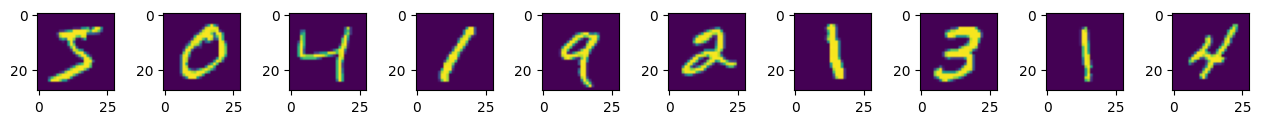

In [7]:
# Adjust for display; high w/h ratio recommended
plt.figure(figsize=(16, 1))

def show_images(dataset, num_samples=10):
    for i, img in enumerate(dataset):
        if i == num_samples:
            return
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(torch.squeeze(img[0]))

show_images(train_set)

### Building the UNet

#### Time Embeddings
The time embedding is important in diffusion models to keep track of what stage the image has been de-noised. However, since time is a scalar, it needs to be converted into the right latent dimension size to be interpreted by the model.
To acheive this, we use a position encoding to encode the timestep.

In [8]:
def get_time_embedding(timesteps, embedding_dim):
    """
    Create sinusoidal time embeddings.

    :param timesteps: (B,) tensor of timesteps.
    :param embedding_dim: Dimension of the embeddings to create.
    :return: (B, embedding_dim) tensor of embeddings.
    """
    assert embedding_dim % 2 == 0, "Embedding dimension must be even"

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)
    emb = timesteps.unsqueeze(1) * emb.unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
    return emb

#### Down Block


In [9]:
# Down Block
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, down_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.t_emb_dim = t_emb_dim

        self.resnet_conv_first = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                nn.SiLU(),
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            ) for i in range(num_layers)
        ])

        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(self.t_emb_dim, out_channels)
            ) for _ in range(num_layers)
        ])

        self.resnet_conv_second = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            ) for _ in range(num_layers)
        ])

        self.attention_norms = nn.ModuleList([nn.GroupNorm(8, out_channels) for _ in range(num_layers)])
        self.attentions = nn.ModuleList([nn.MultiheadAttention(out_channels, num_heads, batch_first=True) for _ in range(num_layers)])
        self.residual_input_conv = nn.ModuleList([nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1) for i in range(num_layers)])
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels, 4, 2, 1) if self.down_sample else nn.Identity()

    def forward(self, x, t):
        t_emb = get_time_embedding(t, self.t_emb_dim)
        out = x
        for i in range(self.num_layers):
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)

            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn

        out = self.down_sample_conv(out)
        return out


#### Mid Block


In [10]:
# Mid Block
class MidBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.t_emb_dim = t_emb_dim

        self.resnet_conv_first = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                nn.SiLU(),
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            ) for i in range(num_layers + 1)
        ])

        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(self.t_emb_dim, out_channels)
            ) for _ in range(num_layers + 1)
        ])

        self.resnet_conv_second = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            ) for _ in range(num_layers + 1)
        ])

        self.attention_norms = nn.ModuleList([nn.GroupNorm(8, out_channels) for _ in range(num_layers)])
        self.attentions = nn.ModuleList([nn.MultiheadAttention(out_channels, num_heads, batch_first=True) for _ in range(num_layers)])
        self.residual_input_conv = nn.ModuleList([nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1) for i in range(num_layers + 1)])

    def forward(self, x, t):
        t_emb = get_time_embedding(t, self.t_emb_dim)
        out = x

        resnet_input = out
        out = self.resnet_conv_first[0](out)
        out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)

        for i in range(self.num_layers):
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn

            resnet_input = out
            out = self.resnet_conv_first[i + 1](out)
            out = out + self.t_emb_layers[i + 1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i + 1](out)
            out = out + self.residual_input_conv[i + 1](resnet_input)

        return out


#### Up Block

In [11]:
# Up Block
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.t_emb_dim = t_emb_dim

        self.resnet_conv_first = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                nn.SiLU(),
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            ) for i in range(num_layers)
        ])

        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            ) for _ in range(num_layers)
        ])

        self.resnet_conv_second = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            ) for _ in range(num_layers)
        ])

        self.attention_norms = nn.ModuleList([nn.GroupNorm(8, out_channels) for _ in range(num_layers)])
        self.attentions = nn.ModuleList([nn.MultiheadAttention(out_channels, num_heads, batch_first=True) for _ in range(num_layers)])
        self.residual_input_conv = nn.ModuleList([nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1) for i in range(num_layers)])
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, 4, 2, 1) if self.up_sample else nn.Identity()

    def forward(self, x, out_down, t):
        t_emb = get_time_embedding(t, self.t_emb_dim)
        x = self.up_sample_conv(x)
        x = torch.cat([x, out_down], dim=1)

        out = x
        for i in range(self.num_layers):
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)

            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn

        return out

#### The UNet


In [12]:
# UNet
class Unet(nn.Module):
    def __init__(self, model_config):
        super().__init__()

        im_channels = model_config['im_channels']
        self.down_channels = model_config['down_channels']
        self.mid_channels = model_config['mid_channels']
        self.t_emb_dim = model_config['time_emb_dim']
        self.down_sample = model_config['down_sample']
        self.num_down_layers = model_config['num_down_layers']
        self.num_mid_layers = model_config['num_mid_layers']
        self.num_up_layers = model_config['num_up_layers']

        assert self.mid_channels[0] == self.down_channels[-1]
        assert self.mid_channels[-1] == self.down_channels[-2]
        assert len(self.down_sample) == len(self.down_channels) - 1

        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=1)

        self.downs = nn.ModuleList([
            DownBlock(self.down_channels[i], self.down_channels[i + 1], self.t_emb_dim,
                      down_sample=self.down_sample[i], num_layers=self.num_down_layers)
            for i in range(len(self.down_channels) - 1)
        ])

        self.mids = nn.ModuleList([
            MidBlock(self.mid_channels[i], self.mid_channels[i + 1], self.t_emb_dim,
                     num_layers=self.num_mid_layers)
            for i in range(len(self.mid_channels) - 1)
        ])

        self.ups = nn.ModuleList([
            UpBlock(self.down_channels[i] * 2, self.down_channels[i - 1] if i != 0 else 16,
                    self.t_emb_dim, up_sample=self.down_sample[i], num_layers=self.num_up_layers)
            for i in reversed(range(len(self.down_channels) - 1))
        ])

        self.norm_out = nn.GroupNorm(8, 16)
        self.conv_out = nn.Conv2d(16, im_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        t = torch.as_tensor(t).long().view(-1)
        out = self.conv_in(x)

        down_outs = []
        for down in self.downs:
            down_outs.append(out)
            out = down(out, t)

        for mid in self.mids:
            out = mid(out, t)

        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t)

        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        return out


#### Noise Scheduler

In [13]:
class LinearNoiseScheduler:
    def __init__(self, num_timesteps, beta_start, beta_end, device):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        self.betas = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod)

    def add_noise(self, original, noise, t):
        batch_size = original.shape[0]
        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod[t].reshape(batch_size, *([1] * (len(original.shape) - 1)))
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size, *([1] * (len(original.shape) - 1)))
        return sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise

    def sample_prev_timestep(self, xt, noise_pred, t):
        batch_size = xt.shape[0]
        sqrt_one_minus_alpha_cum_prod_t = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size, *([1] * (len(xt.shape) - 1)))
        alpha_cum_prod_t = self.alpha_cum_prod[t].reshape(batch_size, *([1] * (len(xt.shape) - 1)))

        x0 = (xt - sqrt_one_minus_alpha_cum_prod_t * noise_pred) / torch.sqrt(alpha_cum_prod_t)
        x0 = torch.clamp(x0, -1., 1.)

        mean = xt - ((self.betas[t].reshape(batch_size, *([1] * (len(xt.shape) - 1))) * noise_pred) / sqrt_one_minus_alpha_cum_prod_t)
        mean = mean / torch.sqrt(self.alphas[t].reshape(batch_size, *([1] * (len(xt.shape) - 1))))

        if t[0] == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod[t - 1]) / (1.0 - self.alpha_cum_prod[t])
            variance = variance * self.betas[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape, device=self.device)
            return mean + sigma.reshape(batch_size, *([1] * (len(xt.shape) - 1))) * z, x0

### Training the Diffusion Model

#### Training and Model Parameters

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Configuration
diffusion_config = {
    'num_timesteps': 1000,
    'beta_start': 0.0001,
    'beta_end': 0.02,
    'device' : device,
}
model_config = {
    'im_channels': 1,
    'im_size': 28,
    'down_channels': [32, 64, 128, 256],
    'mid_channels': [256, 256, 128],
    'down_sample': [True, True, False],
    'time_emb_dim': 128,
    'num_down_layers': 4, #4,
    'num_mid_layers': 4, #4,
    'num_up_layers': 4, #4,
    'num_heads': 4,
}
train_config = {
    'task_name': 'mnist_diffusion',
    'batch_size': 256, # Reduced batch size 256,
    'num_epochs': 50, #50,
    'lr': 1e-4,
    'ckpt_name': 'ddpm_ckpt.pth',
    'model_ckpt_name': 'ddpm_model_ckpt.pth',
}

#### Training Loop

In [15]:
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

In [16]:
def train(model, train_loader, scheduler, optimizer, criterion, num_epochs, device, save_path):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()

            images = batch[0].to(device)
            noise = torch.randn_like(images).to(device)
            timesteps = torch.randint(0, scheduler.num_timesteps, (images.shape[0],)).to(device)

            noisy_images = scheduler.add_noise(images, noise, timesteps)
            predicted_noise = model(noisy_images, timesteps)

            loss = criterion(predicted_noise, noise)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
        torch.save(model.state_dict(), save_path)

    print("Training completed.")

In [17]:
# Setup
scheduler = LinearNoiseScheduler(**diffusion_config)

# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# dataloader = DataLoader(dataset, batch_size=train_config['batch_size'],
#                         shuffle=True, num_workers=4)

dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                     download=True, transform=transform)

# Define subset size
subset_size = 5000  # Use only 5,000 samples for training

# Create a random sampler to select a subset of indices
indices = list(range(len(dataset)))
sampler = SubsetRandomSampler(indices[:subset_size])

# Create the DataLoader using the subset sampler
dataloader = DataLoader(dataset, batch_size=train_config['batch_size'], sampler=sampler, num_workers=4)


# Model
model = Unet(model_config).to(device)
optimizer = Adam(model.parameters(), lr=train_config['lr'])
criterion = nn.MSELoss()

# Training
save_path = os.path.join(train_config['task_name'], train_config['ckpt_name'])
os.makedirs(train_config['task_name'], exist_ok=True)
train(model, dataloader, scheduler, optimizer, criterion, train_config['num_epochs'], device, save_path)


print("Training completed.")

Epoch 1/50: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Epoch 1/50, Loss: 0.8929


Epoch 2/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 2/50, Loss: 0.5628


Epoch 3/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 3/50, Loss: 0.3640


Epoch 4/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 4/50, Loss: 0.2576


Epoch 5/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 5/50, Loss: 0.2021


Epoch 6/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 6/50, Loss: 0.1666


Epoch 7/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 7/50, Loss: 0.1417


Epoch 8/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 8/50, Loss: 0.1240


Epoch 9/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 9/50, Loss: 0.1101


Epoch 10/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 10/50, Loss: 0.0976


Epoch 11/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 11/50, Loss: 0.0881


Epoch 12/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 12/50, Loss: 0.0820


Epoch 13/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 13/50, Loss: 0.0768


Epoch 14/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 14/50, Loss: 0.0706


Epoch 15/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 15/50, Loss: 0.0656


Epoch 16/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 16/50, Loss: 0.0621


Epoch 17/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 17/50, Loss: 0.0614


Epoch 18/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 18/50, Loss: 0.0572


Epoch 19/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 19/50, Loss: 0.0556


Epoch 20/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 20/50, Loss: 0.0523


Epoch 21/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 21/50, Loss: 0.0507


Epoch 22/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 22/50, Loss: 0.0510


Epoch 23/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 23/50, Loss: 0.0482


Epoch 24/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 24/50, Loss: 0.0476


Epoch 25/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 25/50, Loss: 0.0451


Epoch 26/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 26/50, Loss: 0.0451


Epoch 27/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 27/50, Loss: 0.0425


Epoch 28/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 28/50, Loss: 0.0440


Epoch 29/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 29/50, Loss: 0.0415


Epoch 30/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 30/50, Loss: 0.0424


Epoch 31/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 31/50, Loss: 0.0414


Epoch 32/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 32/50, Loss: 0.0398


Epoch 33/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 33/50, Loss: 0.0397


Epoch 34/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 34/50, Loss: 0.0389


Epoch 35/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 35/50, Loss: 0.0384


Epoch 36/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 36/50, Loss: 0.0385


Epoch 37/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 37/50, Loss: 0.0386


Epoch 38/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 38/50, Loss: 0.0370


Epoch 39/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 39/50, Loss: 0.0361


Epoch 40/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 40/50, Loss: 0.0366


Epoch 41/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 41/50, Loss: 0.0353


Epoch 42/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 42/50, Loss: 0.0357


Epoch 43/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 43/50, Loss: 0.0348


Epoch 44/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 44/50, Loss: 0.0346


Epoch 45/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 45/50, Loss: 0.0337


Epoch 46/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 46/50, Loss: 0.0339


Epoch 47/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 47/50, Loss: 0.0325


Epoch 48/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 48/50, Loss: 0.0326


Epoch 49/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 49/50, Loss: 0.0335


Epoch 50/50: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch 50/50, Loss: 0.0321
Training completed.
Training completed.


In [25]:
torch.save(model, os.path.join(train_config['task_name'], train_config['model_ckpt_name']))

### Sampling the Diffusion Model

In [18]:
def sample(model, scheduler, num_samples, image_size, channels, device):
    """
    Generate samples from a trained diffusion model.

    :param model: The trained UNet model.
    :param scheduler: The noise scheduler.
    :param num_samples: Number of images to generate.
    :param image_size: Size of the images to generate.
    :param channels: Number of channels in the images.
    :param device: The device to run the sampling on.
    :return: Generated images as a tensor.
    """
    model.eval()
    with torch.no_grad():
        # Start from pure noise
        x = torch.randn(num_samples, channels, image_size, image_size).to(device)

        # Iteratively denoise the images
        for i in tqdm(reversed(range(scheduler.num_timesteps)), desc='Sampling'):
            t = torch.full((num_samples,), i, device=device, dtype=torch.long)
            predicted_noise = model(x, t)

            # Compute the previous noisy sample x_t -> x_t-1
            x, _ = scheduler.sample_prev_timestep(x, predicted_noise, t)

    # Rescale and clamp the image to be in [0, 1] range
    x = (x.clamp(-1, 1) + 1) / 2
    return x


####Sampling from the trained model  

In [19]:
# After training, generate samples
num_samples = 16
generated_samples = sample(model, scheduler, num_samples, model_config['im_size'], model_config['im_channels'], device)

# Create a grid of images
img_grid = make_grid(generated_samples, nrow=4)

# Convert to PIL Image
img_grid_pil = torchvision.transforms.ToPILImage()(img_grid)

# Save the image grid
img_grid_pil.save(os.path.join(train_config['task_name'], 'generated_samples.png'))

print(f"Generated samples saved to {os.path.join(train_config['task_name'], 'generated_samples.png')}")


Sampling: 1000it [00:40, 24.69it/s]

Generated samples saved to mnist_diffusion/generated_samples.png


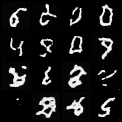

In [22]:
from IPython.display import Image, display
import ipywidgets as widgets
display(Image(filename=os.path.join(train_config['task_name'], 'generated_samples.png')))

#### Sampling from a checkpointed model

In [30]:
import torch
import torchvision
from torchvision.utils import make_grid
from PIL import Image
from tqdm import tqdm
import os
import imageio

def load_model_from_checkpoint(model, checkpoint_path, device):
    """
    Load a model from a checkpoint, ignoring mismatched keys.

    :param model: The model architecture (uninitialized).
    :param checkpoint_path: Path to the checkpoint file.
    :param device: The device to load the model onto.
    :return: The loaded model.
    """
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location=device)

    # If the checkpoint contains the full model, not just the state dict
    if isinstance(checkpoint, dict) and 'state_dict' in checkpoint:
        checkpoint = checkpoint['state_dict']

    # Filter out unexpected keys
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict}

    # Update model state dict
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    model.to(device)
    model.eval()

    print(f"Loaded checkpoint from {checkpoint_path}")
    print(f"Loaded {len(pretrained_dict)} / {len(model_dict)} layers")

    return model

def sample_and_create_gif(checkpoint_path, model, scheduler, num_samples, image_size, channels, device, output_dir, num_gif_frames=100):
    """
    Generate samples from a trained diffusion model checkpoint and create a GIF of the process.

    :param checkpoint_path: Path to the model checkpoint.
    :param model: The UNet model architecture (uninitialized).
    :param scheduler: The noise scheduler.
    :param num_samples: Number of images to generate.
    :param image_size: Size of the images to generate.
    :param channels: Number of channels in the images.
    :param device: The device to run the sampling on.
    :param output_dir: Directory to save the output files.
    :param num_gif_frames: Number of frames to include in the GIF.
    :return: Path to the created GIF.
    """
    model = load_model_from_checkpoint(model, checkpoint_path, device)

    os.makedirs(output_dir, exist_ok=True)

    frames = []
    total_steps = scheduler.num_timesteps
    save_interval = max(total_steps // num_gif_frames, 1)

    with torch.no_grad():
        # Start from pure noise
        x = torch.randn(num_samples, channels, image_size, image_size).to(device)

        # Iteratively denoise the images
        for i in tqdm(reversed(range(total_steps)), desc='Sampling'):
            t = torch.full((num_samples,), i, device=device, dtype=torch.long)
            predicted_noise = model(x, t)

            # Compute the previous noisy sample x_t -> x_t-1
            x, _ = scheduler.sample_prev_timestep(x, predicted_noise, t)

            # Save frame for GIF
            if i % save_interval == 0 or i == total_steps - 1 or i == 0:
                # Rescale and clamp the image to be in [0, 1] range
                frame = (x.clamp(-1, 1) + 1) / 2
                grid = make_grid(frame, nrow=int(num_samples**0.5))
                img = torchvision.transforms.ToPILImage()(grid)
                frames.append(img)

    # Save the GIF
    gif_path = os.path.join(output_dir, 'diffusion_process.gif')
    frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=100, loop=1)

    # Save the final image
    final_image_path = os.path.join(output_dir, 'final_samples.png')
    frames[-1].save(final_image_path)

    return gif_path, final_image_path

# Example usage in main function:
def gen_samples():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Configuration
    diffusion_config = {
        'num_timesteps': 1000,
        'beta_start': 0.0001,
        'beta_end': 0.02,
        'device' : device,
    }
    model_config = {
        'im_channels': 1,
        'im_size': 28,
        'down_channels': [32, 64, 128, 256],
        'mid_channels': [256, 256, 128],
        'down_sample': [True, True, False],
        'time_emb_dim': 128,
        'num_down_layers': 4,
        'num_mid_layers': 4,
        'num_up_layers': 4,
        'num_heads': 4,
    }
    train_config = {
        'task_name': 'mnist_diffusion',
        'batch_size': 256,
        'num_epochs': 50,
        'lr': 1e-4,
        'ckpt_name': 'ddpm_ckpt.pth',
        'model_ckpt_name': 'ddpm_model_ckpt.pth',
    }


    # Initialize model and scheduler
    model = Unet(model_config)
    scheduler = LinearNoiseScheduler(**diffusion_config)

    # Set up checkpoint path and output directory
    checkpoint_path = os.path.join(train_config['task_name'], train_config['ckpt_name'])
    # checkpoint_path = "./pretrained/trained_ddpm_ckpt.pth"
    output_dir = os.path.join(train_config['task_name'], 'visualization')

    # Generate samples and create GIF
    num_samples = 25
    gif_path, final_image_path = sample_and_create_gif(
        checkpoint_path, model, scheduler, num_samples,
        model_config['im_size'], model_config['im_channels'],
        device, output_dir
    )

    print(f"Diffusion process GIF saved to {gif_path}")
    print(f"Final samples saved to {final_image_path}")

In [31]:
gen_samples()

Loaded checkpoint from mnist_diffusion/ddpm_ckpt.pth
Loaded 618 / 618 layers


Sampling: 1000it [00:43, 23.12it/s]


Diffusion process GIF saved to mnist_diffusion/visualization/diffusion_process.gif
Final samples saved to mnist_diffusion/visualization/final_samples.png


Note how long this takes to generate? Maybe in the next lesson we can speed things up.

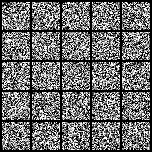

In [32]:
from IPython.display import Image, display
import ipywidgets as widgets
display(Image(filename='/content/mnist_diffusion/visualization/diffusion_process.gif'))